In [11]:
import torch
import tiktoken
from torch.nn import functional as F

In [12]:
computeDevice = torch.device("cpu")
if torch.cuda.is_available():
    computeDevice = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    computeDevice = torch.device("mps")
    
print(f"Using Compute Device: {computeDevice}")

Using Compute Device: mps


In [13]:
enc = tiktoken.get_encoding('gpt2')
with open('input.txt', 'r') as f:
    text = f.read()

print(len(text))
trainText = text[:1000]
tokens = enc.encode(trainText)

B, T = 4, 32
buf = torch.tensor(tokens[:B*T + 1], device=computeDevice)
x = buf[:-1].view(B, T)
y = buf[1:].view(B, T)

print(x.shape)
print(y.shape)

1115394
torch.Size([4, 32])
torch.Size([4, 32])


In [14]:
from train_gpt2 import GPT, GPTConfig

model = GPT(GPTConfig())
model.to(computeDevice)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [15]:
with torch.no_grad():
    logits, loss = model(x,y)
    print(logits.shape)
    print(loss)

torch.Size([4, 32, 50257])
tensor(10.8360, device='mps:0')


In [16]:
from data_loader import DataLoaderLite

torch.manual_seed(1337)

dataset = DataLoaderLite(B, T)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []
for i in range(50):
    optimizer.zero_grad()
    x, y = dataset.next_batch()
    x, y = x.to(computeDevice), y.to(computeDevice)
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    print(f"Step {i}, loss: {loss.item()}")
    losses.append(loss.item())


Loaded 338025 tokens
1 epoch = 2640 batches
Step 0, loss: 10.836030960083008
Step 1, loss: 9.719564437866211
Step 2, loss: 9.055830955505371
Step 3, loss: 9.235494613647461
Step 4, loss: 8.660428047180176
Step 5, loss: 8.273024559020996
Step 6, loss: 9.031418800354004
Step 7, loss: 8.702554702758789
Step 8, loss: 8.204258918762207
Step 9, loss: 8.069696426391602
Step 10, loss: 8.380194664001465
Step 11, loss: 7.477408409118652
Step 12, loss: 7.889606475830078
Step 13, loss: 7.514639854431152
Step 14, loss: 7.620720386505127
Step 15, loss: 7.337192535400391
Step 16, loss: 7.450829982757568
Step 17, loss: 8.239480972290039
Step 18, loss: 7.255712509155273
Step 19, loss: 7.851762771606445
Step 20, loss: 7.577338218688965
Step 21, loss: 7.9191999435424805
Step 22, loss: 6.507256507873535
Step 23, loss: 6.915849685668945
Step 24, loss: 6.98557186126709
Step 25, loss: 6.7891130447387695
Step 26, loss: 6.863680839538574
Step 27, loss: 7.681197643280029
Step 28, loss: 7.203378677368164
Step 29

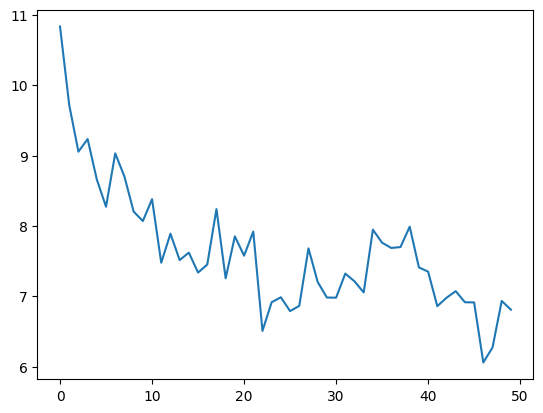

In [17]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [18]:
torch.mps.empty_cache() #GPUPoor

evalText = text[1000:]
evalData = enc.encode(evalText)
B, maxT = 8, 512

x = torch.tensor(evalData[:B * maxT], device=computeDevice)
x = x.view(B, maxT)

# evalText = "Second Citizen:\nWould you proceed especially against Caius Marcius?"
# evalData = enc.encode(evalText)
# x = torch.tensor(evalData, device=computeDevice)
# x = x.view(1, -1)

with torch.no_grad():
    logits, loss = model(x)
    logits = logits[:,-1,:]
    probs = F.softmax(logits, dim=-1)
    # do top-k sampling of 50
    topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
    ix = torch.multinomial(topk_probs, 1) # (B,1)
    xcol = torch.gather(topk_indices, -1, ix)
    x = torch.cat((x, xcol), dim=1)

In [32]:
print(enc.decode(x[i,:-1].tolist()))
print("***" * 10)
for i in range(x.size(0)):
    print("--")
    print(enc.decode([x[i,-1].tolist()]))

They have press'd a power, but it is not known
Whether for east or west: the dearth is great;
The people mutinous; and it is rumour'd,
Cominius, Marcius your old enemy,
Who is of Rome worse hated than of you,
And Titus Lartius, a most valiant Roman,
These three lead on this preparation
Whither 'tis bent: most likely 'tis for you:
Consider of it.'

First Senator:
Our army's in the field
We never yet made doubt but Rome was ready
To answer us.

AUFIDIUS:
Nor did you think it folly
To keep your great pretences veil'd till when
They needs must show themselves; which
in the hatching,
It seem'd, appear'd to Rome. By the discovery.
We shall be shorten'd in our aim, which was
To take in many towns ere almost Rome
Should know we were afoot.

Second Senator:
Noble Aufidius,
Take your commission; hie you to your bands:
Let us alone to guard Corioli:
If they set down before 's, for the remove
Bring your army; but, I think, you'll find
They've not prepared for us.

AUFIDIUS:
O, doubt not that;
I sp